<a href="https://colab.research.google.com/github/hallpaz/3dsystems21/blob/main/assignments/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7 - 3D Graphics Systems - IMPA 2021
## Rendering textured pointclouds and meshes

In [ ]:
# Initial Setup
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0   2226      0 --:--:-- --:--:-- --:--:--  2226
100  404k    0  404k    0     0  2468k      0 --:--:-- --:--:-- --:--:-- 2468k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-kdedk9bs
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-kdedk9bs
  Running command git checkout -q 18ce14cd31a2f1c99e16d727e1755156c360453a
     |████████████████████████████████| 645kB 10.4MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20515558 sha256=3650d2af02a5aa6da5c13786e81728107f25083c7710dcd66983e27bef960f21
  Stored in directory: /tmp/pip-ephem-wheel-cache-_2t3wtlo/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



⚠️ ⚠️ ⚠️  If using **Google Colab**, fetch the utils file for plotting image grids:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-02-08 10:11:26--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-02-08 10:11:26 (11.9 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



In [ ]:
# uncomment and run this line if running locally
# from utils import image_grid

# Part 1 - Loading a textured mesh and visualizing its texture map

0.1 Download a textured mesh set of files. The .obj describes the mesh structure; The .mtl describes its material and the image (.png) is a texture map.

In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-02-08 10:11:31--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.04s   

2021-02-08 10:11:31 (7.58 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-02-08 10:11:31--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

1.1 Load the mesh data using the function `load_objs_as_meshes`. It takes a list of paths to one or multiple .obj file and returns a Meshes object. Don't forget to pass the `device` as argument, so you can benefit of the GPU acceleration.

1.2 Visualize the texture map loaded with the mesh. You can use the function `texturesuv_image_matplotlib` passing the attribute `textures` of the Meshes instance. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

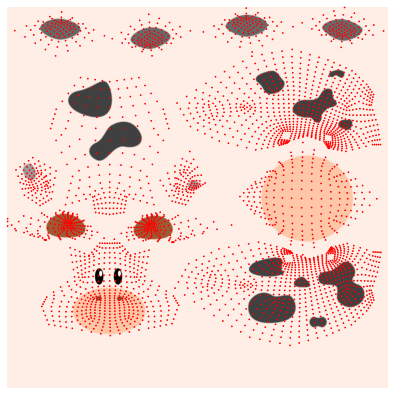

In [ ]:
##############################################################################
# Code for 1.1-1.2.
##############################################################################

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

# Part 2 - Rendering a Mesh

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest. We will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **phong shading**.

In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

## 3. Render the mesh

2.0 Run the following cell to use the `renderer` function to render the mesh. It takes a Meshes object and returns a tensor that you can interpret as an image.

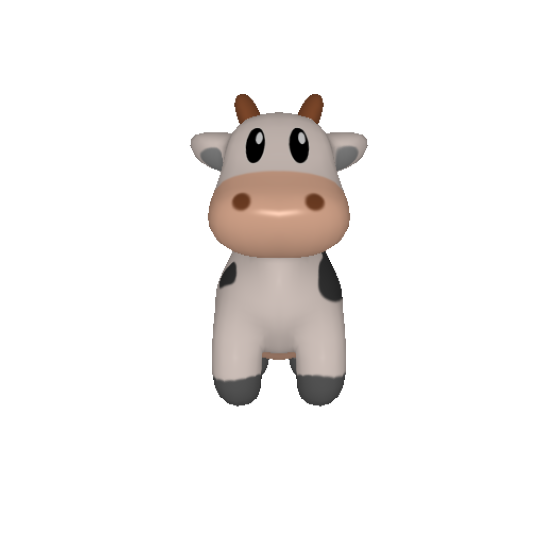

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [ ]:
from pytorch3d.renderer import ( 
    SoftGouraudShader,
    SoftSilhouetteShader,
    HardFlatShader
)

2.1 Move the light by changing its location coordinates and render the scene again. You don't need to recreate the renderer to specify a new light setting. When you call your renderer, you can pass a **lights parameter**: `renderer(mesh, lights=newlights)`


2.2 Experiment to define a new renderer using the `HardFlatShader` and render the mesh. 

2.3 - We can also change the material of a batch of meshes. Define a new `Material` object and experiment changing the **material reflectance** properties of the mesh by specifying new values for the attributes `specular_color` and `shininess`. Again, you can pass a materials parameter as you call your renderer: `renderer(mesh, material=newmaterial)`


#### **You are going to learn more about illumination models in a few weeks. For now, just try to run these experiments to get used to the APIs available in PyTorch3D and write your comments based on your observations.**


In [ ]:
##############################################################################
# Code for 2.1-2.3.
##############################################################################

### Extra
E.1 Compute the estimated normals for each vertex of the mesh and render a normal map using the `SoftGouraudShader`.

In [ ]:
##############################################################################
# Code for E.1
##############################################################################

## Parte 3 - Moving the scene

In [ ]:
from pytorch3d.transforms import Transform3d, Rotate, Translate



3.1 Check the documentation for the function `look_at_view_transform`. It gives us an intuitive way to define a virtual camera, returning a rotation matrix and translation vector to be applied on the scene. Define a new camera and render the scene from another viewpoint by passing the parameter `cameras` to your renderer: `renderer(mesh, cameras=newcamera)` .

3.2 In addition to moving the camera, we can move the object too, by applying a transformation to its vertices. Rotate the mesh by 90 degrees around the vertical axis (Y) and render the scene.

In [ ]:
##############################################################################
# Code for 3.1-3.2.
##############################################################################

## Part 4. Batched Rendering

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


3.0 Run the following cells and observe how the operations are executed in batches.

In [ ]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

In [ ]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

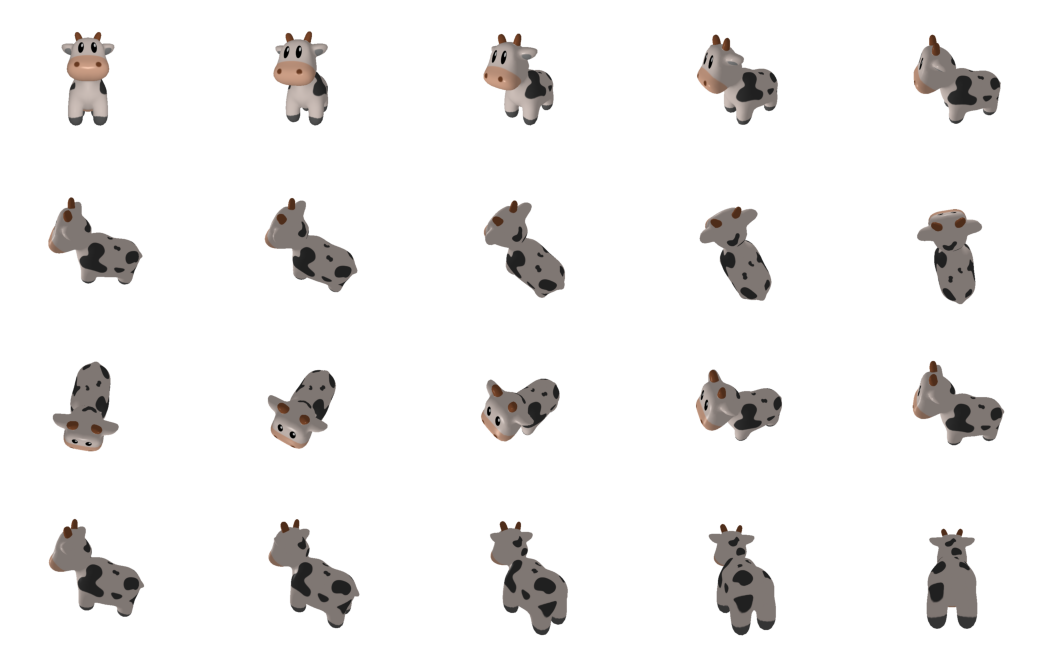

In [ ]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

4.2 Create a batch of 2 meshes and use the function `image_grid` to show two different images so that the leftmost should be facing the right direction, while the rightmost should be facing the left direction.

4.1 Use any configuration of camera and object transformations to render **a single image** of a scene with two equal objects facing each other with some space between them.

In [ ]:
##############################################################################
# Code for 4.1-4.2.
##############################################################################

## Part 5. Rendering Point Clouds

In [ ]:
import numpy as np

from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

### Load a point cloud and corresponding colors

Load and create a **Point Cloud** object. 

**Pointclouds** is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes. 

If running this notebook using **Google Colab**, run the following cell to fetch the pointcloud data and save it at the path `data/PittsburghBridge`:
If running locally, the data is already available at the correct path. 

In [ ]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2021-02-08 10:16:13--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘data/PittsburghBridge/pointcloud.npz’

pointcloud.npz      100%[===================>]   5.44M  --.-KB/s    in 0.09s   

2021-02-08 10:16:13 (60.6 MB/s) - ‘data/PittsburghBridge/pointcloud.npz’ saved [5701352/5701352]



In [ ]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")
# Load point cloud and colors
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)        
rgb = torch.Tensor(pointcloud['rgb']).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgb])

In [ ]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily).
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
pcrenderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

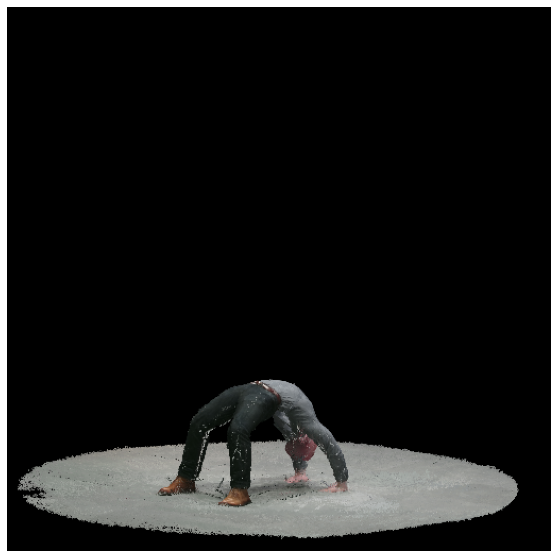

In [ ]:
images = pcrenderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

We will now modify the **renderer** to use **weighted compositing** with a set background color. 

In [ ]:
pcrenderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    # Pass in background_color to the norm weighted compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case red
    compositor=NormWeightedCompositor(background_color=(1,0,0))
)

5.1 Render and display a new image of the PointCloud.

5.2 Experiment changing the background color

In [ ]:
##############################################################################
# Code for 5.1-5.2.
##############################################################################

## Using the pulsar backend

Switching to the pulsar backend is easy! The pulsar backend has a compositor built-in, so the `compositor` argument is not required when creating it (a warning will be displayed if you provide it nevertheless). It pre-allocates memory on the rendering device, that's why it needs the `n_channels` at construction time.

All parameters for the renderer forward function are batch-wise except the background color (in this example, `gamma`) and you have to provide as many values as you have examples in your batch. The background color is optional and by default set to all zeros. You can find a detailed explanation of how gamma influences the rendering function here in the paper [Fast Differentiable Raycasting for Neural Rendering using
Sphere-based Representations](https://arxiv.org/pdf/2004.07484.pdf).

You can also use the `native` backend for the pulsar backend which already provides access to point opacity. The native backend can be imported from `pytorch3d.renderer.points.pulsar`; you can find examples for this in the folder `docs/examples`.

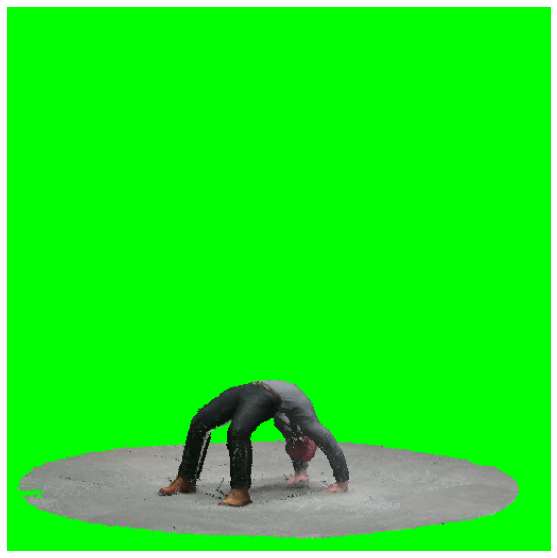

In [ ]:
pcrenderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = pcrenderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

5.3 Create a batch of pointclouds and render the scene with different viewpoints and background colors.

In [ ]:
##############################################################################
# Code for 5.1-5.2.
##############################################################################

## Part 6. Plotly visualization 
You already know we can visualize meshes with Plotly - we used it in the last assignment to show some ShapeNet models. We can use Plotly to visualize point clouds too!

6.1 Use the function `plot_scene` to visualize a point cloud.

6.2 Create a batch of pointclouds and *render all of them in the same subplot* using `plot_scene`. To avoid overlap, add a translation offset to the points of different instances.

6.3 Show the batch of point clouds using the function `plot_batch_individually`

*You are free to experiment any configuration of figure size, axis visibility and axis colors.*

In [ ]:
##############################################################################
# Code for 6.1-6.3.
##############################################################################